In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torchdiffeq import odeint

from pit.dynamics.kinematic_bicycle_f110 import KinematicBicycle_Steer
from pit.integration import Euler, RK4
from pit.data_processor.csv_loader import fetch_aligned_trajectory_data

import matplotlib.pyplot as plt
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [2]:
import math

## Helper Functions

In [470]:
class KinematicBicycle_Steer(nn.Module):
    """
    """

    def __init__(self, lwb, st_delay, accel_delay, params_index) -> None:
        super().__init__()
        self.lwb = torch.nn.Parameter(torch.tensor(lwb, dtype=torch.float32))
        self.steer_delay_time = torch.nn.Parameter(torch.tensor(st_delay, dtype=torch.float32))
        self.accel_delay_time = torch.nn.Parameter(torch.tensor(accel_delay, dtype=torch.float32))
        self.accel_max = torch.nn.Parameter(torch.tensor(10.0, dtype=torch.float32))
        self.accel_min = torch.nn.Parameter(torch.tensor(-10.0, dtype=torch.float32))
        self.steer_k = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float32))
        self.steer_b = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.speed_k = torch.nn.Parameter(torch.tensor(0.97, dtype=torch.float32))
        # Define indexes for states and control inputs
        for key, value in params_index.items():
            setattr(self, key, value)
        # real U: steer, velocity
        # model U: steer_vel, accel.

    def forward(self, states, control_inputs):
        """ Get the evaluated ODEs of the state at this point

        Args:
            states (): Shape of (B, 5) or (5)
            control_inputs (): Shape of (B, 2) or (2)
        """
        batch_mode = True if len(states.shape) == 2 else False
        diff = torch.zeros_like(states)

        
        if batch_mode:
            steer = self.steer_k*states[:, self.DELTA] + self.steer_b
            desired_vel = control_inputs[:, self.VEL]*self.speed_k
            current_vel = states[:, self.V]
            accel = (desired_vel - current_vel) / self.accel_delay_time
            
            diff[:, self.X] = states[:, self.V] * torch.cos(states[:, self.YAW])
            diff[:, self.Y] = states[:, self.V] * torch.sin(states[:, self.YAW])
            diff[:, self.DELTA] = self.steer_k*(control_inputs[:, self.STEER] - states[:, self.DELTA]) / self.steer_delay_time
            diff[:, self.YAW] = (states[:, self.V] * torch.tan(steer)) / self.lwb
            diff[:, self.V] = torch.clamp(accel, self.accel_min, self.accel_max)
        else:
            steer = self.steer_k*states[self.DELTA] + self.steer_b
            desired_vel = control_inputs[self.VEL]*self.speed_k
            current_vel = states[self.V]
            accel = (desired_vel - current_vel) / self.accel_delay_time
            
            diff[self.X] = states[self.V] * torch.cos(states[self.YAW])
            diff[self.Y] = states[self.V] * torch.sin(states[self.YAW])
            diff[self.DELTA] = self.steer_k*(control_inputs[self.STEER] - states[self.DELTA]) / self.steer_delay_time
            # diff[YAW] = (states[V] * torch.tan(control_inputs[STEER])) / self.lwb
            diff[self.YAW] = (states[self.V] * torch.tan(steer)) / self.lwb
            diff[self.V] = torch.clamp(accel, self.accel_min, self.accel_max)
        return diff

In [471]:
X, Y, DELTA, YAW, V = 0, 1, 2, 3, 4
STEER, VEL = 0, 1

def plot_states(pred, gt, ti, horizon=None):
    if horizon:
        pred = pred[:horizon, :]
        gt = gt[:horizon, :]
        ti = ti[:horizon]
    fig, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0][0].plot(ti, pred[:, DELTA], label='pred_steer', color='blue')
    ax[0][0].plot(ti, gt[:, DELTA], label='gt_steer', color='red')
    ax[0][0].legend()
    pred[:, YAW] = (pred[:, YAW] + math.pi) % (2 * math.pi) - math.pi
    ax[0][1].plot(ti, pred[:, YAW], label='pred_yaw', color='blue')
    ax[0][1].plot(ti, gt[:, YAW], label='gt_yaw', color='red')
    ax[0][1].legend()
    ax[1][0].plot(ti, pred[:, V], label='pred_v', color='blue')
    ax[1][0].plot(ti, gt[:, V], label='gt_v', color='red')
    # ax[1][0].set_xlabel('Time')
    # ax[1][0].set_ylabel('Value')
    ax[1][0].legend()

    # Plot for XY trajectory
    ax[1][1].plot(pred[:, 0], pred[:, 1], label='Pred Trajectory', color='blue')
    ax[1][1].plot(gt[:, 0], gt[:, 1], label='GT Trajectory', color='red')
    ax[1][1].set_xlabel('x')
    ax[1][1].set_ylabel('y')
    ax[1][1].set_title('XY Trajectory')
    ax[1][1].legend()
    ax[1][1].grid(True)

    plt.tight_layout()
    plt.show()

## Load data from csv files

In [472]:
file_path = "../datasets/skir_1.csv"
sample_interval = 0.04
traj_data = fetch_aligned_trajectory_data(file_path, sample_interval=sample_interval)
cut_off = 100

In [473]:
x = torch.tensor(traj_data['/pf/pose/odom/pose/pose/position/x'].to_numpy())[cut_off:]
y = torch.tensor(traj_data['/pf/pose/odom/pose/pose/position/y'].to_numpy())[cut_off:]
v = torch.tensor(traj_data['/odom/twist/twist/linear/x'].to_numpy())[cut_off:]
yaw = torch.tensor(traj_data['/pf/pose/odom/pose/pose/orientation/yaw_deg'].to_numpy()*np.pi/180)[cut_off:]
ti = torch.tensor(traj_data.index.to_numpy())[cut_off:]

steer = torch.tensor(traj_data['/ackermann_cmd/drive/steering_angle'].to_numpy())[cut_off:]
speed = torch.tensor(traj_data['/ackermann_cmd/drive/speed'].to_numpy())[cut_off:]

initial_state = torch.tensor([x[0],y[0],steer[0],yaw[0],v[0]]).to(DEVICE)
control_inputs = torch.vstack([steer, speed]).T
control_inputs = control_inputs.contiguous().to(DEVICE)
output_states = torch.vstack([x, y, steer, yaw, v]).T.to(DEVICE)
target_states = output_states[1:]
target_states = target_states.contiguous()

In [474]:
print(control_inputs.shape[0])

980


## Train

In [475]:
STEP_GAP=10
HORIZON=50
state_dims = initial_state.shape[0]
input_dims = control_inputs.shape[-1]
total_steps = (control_inputs.shape[0]-HORIZON-1)//STEP_GAP

batched_timestamps = ti[:HORIZON].to(DEVICE)
batched_initial_states = torch.zeros((total_steps, state_dims), device=DEVICE)
batched_control_inputs = torch.zeros((total_steps, HORIZON, input_dims), device=DEVICE)
batched_target_states = torch.zeros((total_steps, HORIZON, state_dims), device=DEVICE)

for step in range(total_steps):
    batched_initial_states[step] = output_states[step*STEP_GAP]
    # batched_timestamps[step] = ti[step*STEP_GAP:(step*STEP_GAP)+HORIZON].view(-1, 1)
    # (10, 60), (20, 70), (30, 80)
    batched_control_inputs[step] = control_inputs[step*STEP_GAP:(step*STEP_GAP)+HORIZON]
    batched_target_states[step] = output_states[(step*STEP_GAP)+1:(step*STEP_GAP)+HORIZON+1]

print(f"Batched Inputs size: {batched_control_inputs.shape} | Batched States size: {batched_target_states.shape}")

Batched Inputs size: torch.Size([92, 50, 2]) | Batched States size: torch.Size([92, 50, 5])


In [476]:
dataset = torch.utils.data.TensorDataset(batched_initial_states, batched_control_inputs, batched_target_states)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [477]:
params_index = {
    "X": 0,
    "Y": 1,
    "DELTA": 2,
    "YAW": 3,
    "V": 4,
    "STEER": 0,
    "VEL": 1
}
kinematic_f110 = KinematicBicycle_Steer(lwb=0.38, st_delay=0.05, accel_delay=0.2, params_index=params_index).to(DEVICE)
kinematic_f110.lwb.requires_grad = False
kinematic_f110.steer_delay_time.requires_grad = False
kinematic_f110.accel_delay_time.requires_grad = False
kinematic_f110.accel_max.requires_grad = True
kinematic_f110.accel_min.requires_grad = True
kinematic_f110.steer_k.requires_grad = True
kinematic_f110.steer_b.requires_grad = False
kinematic_f110.steer_k = torch.nn.Parameter(torch.tensor(1.01, dtype=torch.float32))
euler_integrator = Euler(kinematic_f110, timestep=sample_interval)
rk4_integrator = RK4(kinematic_f110, timestep=sample_interval)
print(sample_interval)

0.04


In [478]:
def kinematic_steer_loss(pred, target, params_index):
    X, Y, YAW, V = params_index["X"], params_index["Y"], params_index["YAW"], params_index["V"]
    indices = [X, Y, V]
    pred_selected = pred[..., indices]
    target_selected = target[..., indices]
    # NOTE: can not modify the varibale inplace, so yaw is regularized separately
    regularize_yaw =  (pred[..., YAW] + math.pi) % (2 * math.pi) - math.pi
    
    # Compute the L1 loss
    return torch.abs(pred_selected - target_selected).mean() + torch.abs(regularize_yaw - target[..., YAW]).mean()

### View trajectory data

In [479]:
with torch.no_grad():
    pred = rk4_integrator(initial_state, control_inputs)
    val_loss = kinematic_steer_loss(pred, output_states, params_index=params_index)
    print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

Initialized | Validation Loss: 0.601844228253825 | LR: 0.003874204890000002


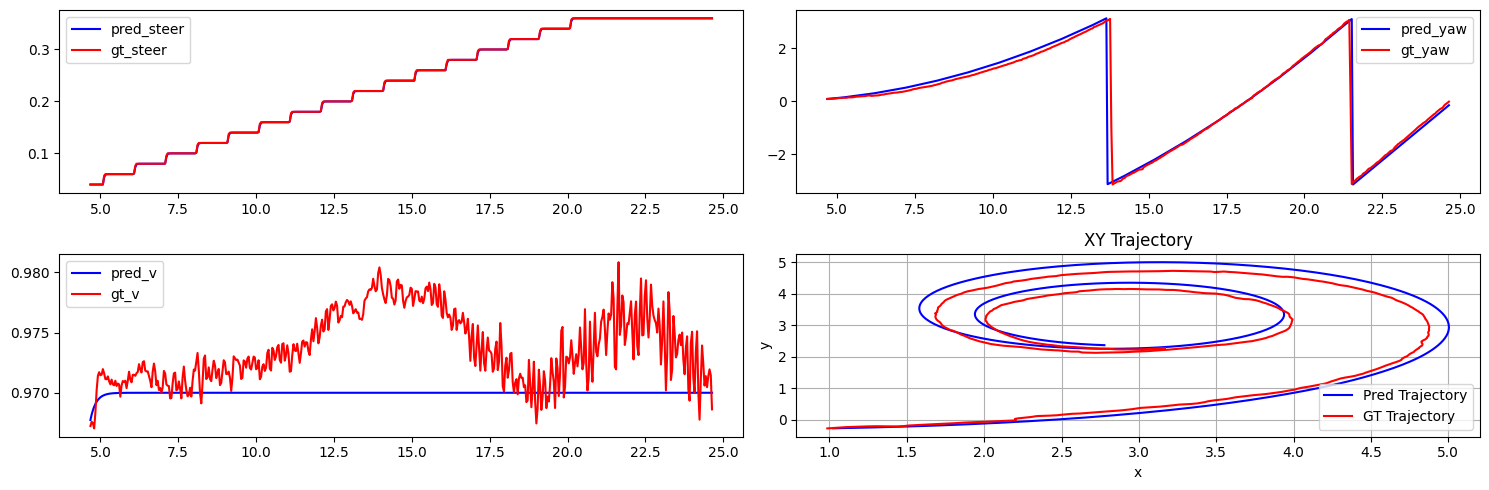

In [480]:
plot_states(pred.cpu().detach().numpy(), output_states.cpu().detach().numpy(), ti, horizon=500)

### View batched data

In [485]:
with torch.no_grad():
    for initial, inputs, targets in dataloader:
        print(initial.shape, inputs.shape, targets.shape)
        # batched_traj = integrator(kinematic_f110, initial, inputs, batched_timestamps)
        batched_traj = rk4_integrator(initial, inputs)
        print(batched_traj.shape)
        break

torch.Size([92, 5]) torch.Size([92, 50, 2]) torch.Size([92, 50, 5])
torch.Size([92, 50, 5])


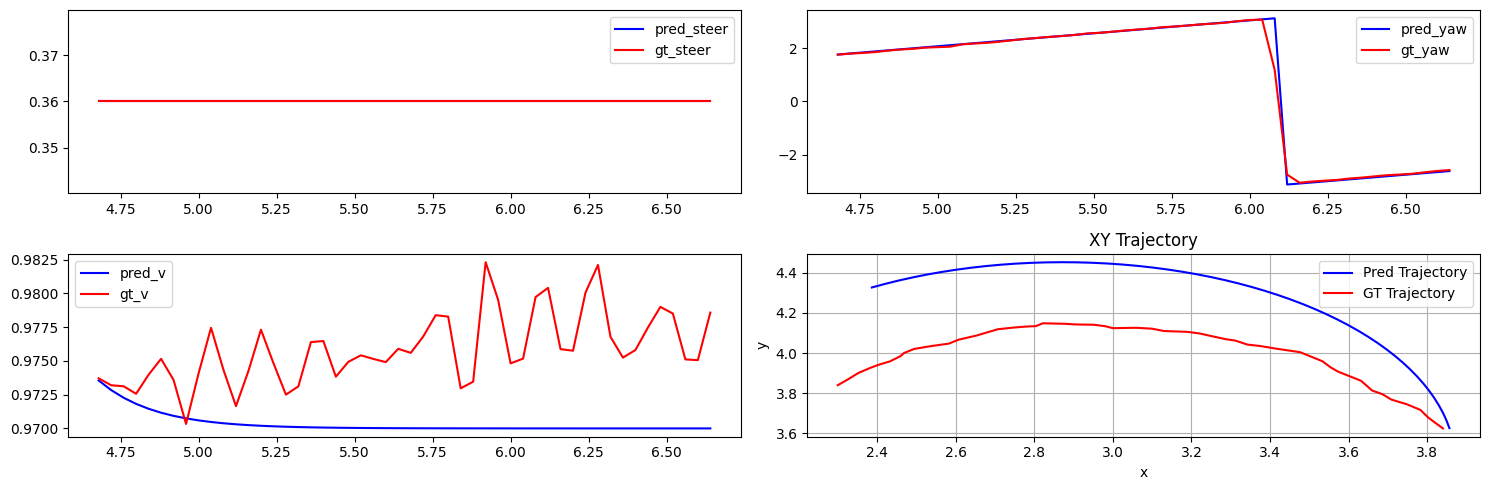

In [486]:
plot_states(batched_traj[2].cpu().detach().numpy(), targets[2].cpu().detach().numpy(), batched_timestamps.cpu().detach().numpy(), horizon=300)

In [396]:
from tqdm.auto import tqdm
EPOCHS = 100
optimizer = torch.optim.SGD(kinematic_f110.parameters(), lr=0.01, momentum=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.9)

  0%|          | 0/100 [00:00<?, ?it/s]

accel_max tensor(10., device='cuda:0') tensor(0., device='cuda:0')
accel_min tensor(-10.0000, device='cuda:0') tensor(-5.5690e-05, device='cuda:0')
steer_k tensor(0.8956) tensor(0.4412)


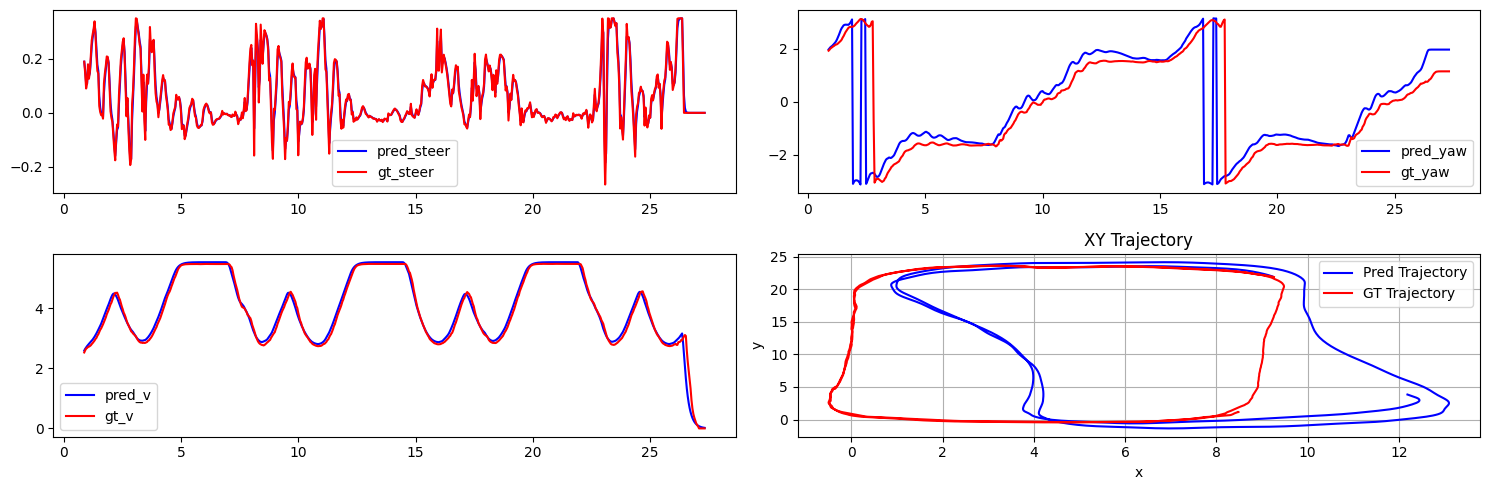

Epoch: 0 | Training Loss: 0.5564959049224854 | Validation Loss: 1.9326089380307505 | LR: 0.01
Epoch: 0 | Training Loss: 0.5564959049224854 | Validation Loss: 1.9326089380307505 | LR: 0.01
Epoch: 1 | Training Loss: 0.5545881986618042 | Validation Loss: 1.9326089380307505 | LR: 0.01
Epoch: 2 | Training Loss: 0.5475576519966125 | Validation Loss: 1.9326089380307505 | LR: 0.01
Epoch: 3 | Training Loss: 0.5338785648345947 | Validation Loss: 1.9326089380307505 | LR: 0.01
Epoch: 4 | Training Loss: 0.5185416340827942 | Validation Loss: 1.9326089380307505 | LR: 0.01
accel_max tensor(10., device='cuda:0') tensor(0., device='cuda:0')
accel_min tensor(-10.0000, device='cuda:0') tensor(-5.3935e-05, device='cuda:0')
steer_k tensor(0.8407) tensor(0.2550)
Epoch: 5 | Training Loss: 0.5072104334831238 | Validation Loss: 1.9326089380307505 | LR: 0.01
Epoch: 6 | Training Loss: 0.4985111951828003 | Validation Loss: 1.9326089380307505 | LR: 0.01
Epoch: 7 | Training Loss: 0.49045199155807495 | Validation Los

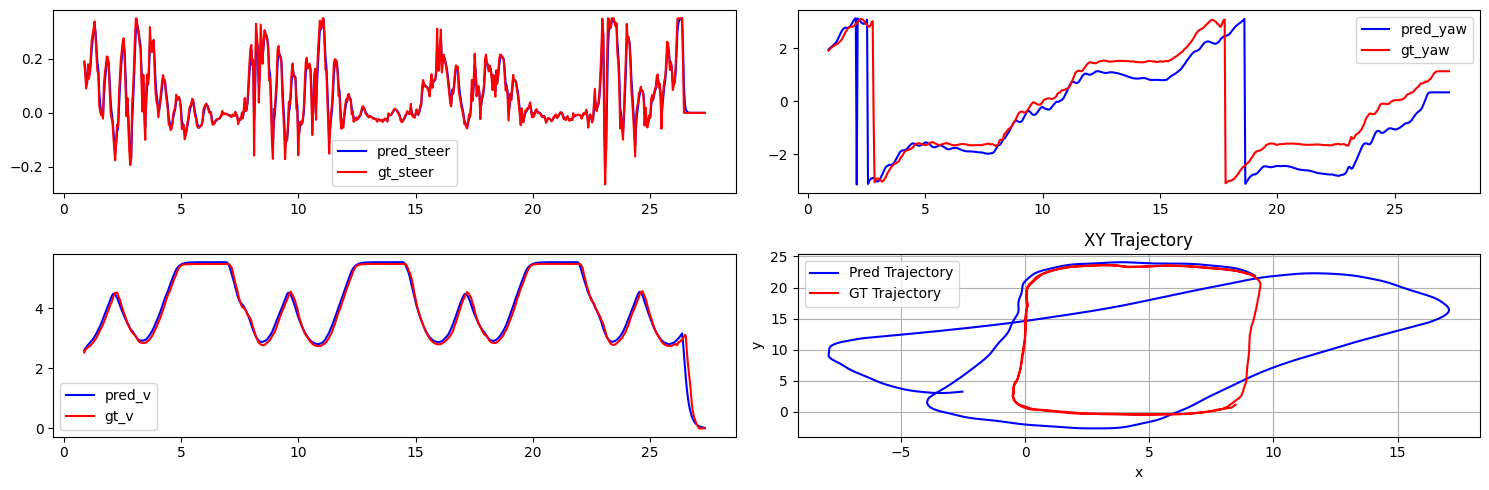

Epoch: 20 | Training Loss: 0.4828089475631714 | Validation Loss: 3.3652859846572096 | LR: 0.009000000000000001
Epoch: 20 | Training Loss: 0.4828089475631714 | Validation Loss: 3.3652859846572096 | LR: 0.009000000000000001
Epoch: 21 | Training Loss: 0.48470938205718994 | Validation Loss: 3.3652859846572096 | LR: 0.009000000000000001
Epoch: 22 | Training Loss: 0.48462292551994324 | Validation Loss: 3.3652859846572096 | LR: 0.009000000000000001
Epoch: 23 | Training Loss: 0.48458072543144226 | Validation Loss: 3.3652859846572096 | LR: 0.008100000000000001
Epoch: 24 | Training Loss: 0.48654842376708984 | Validation Loss: 3.3652859846572096 | LR: 0.008100000000000001
accel_max tensor(10., device='cuda:0') tensor(0., device='cuda:0')
accel_min tensor(-10.0000, device='cuda:0') tensor(-5.1812e-05, device='cuda:0')
steer_k tensor(0.7894) tensor(-0.0127)
Epoch: 25 | Training Loss: 0.4865292012691498 | Validation Loss: 3.3652859846572096 | LR: 0.008100000000000001
Epoch: 26 | Training Loss: 0.486

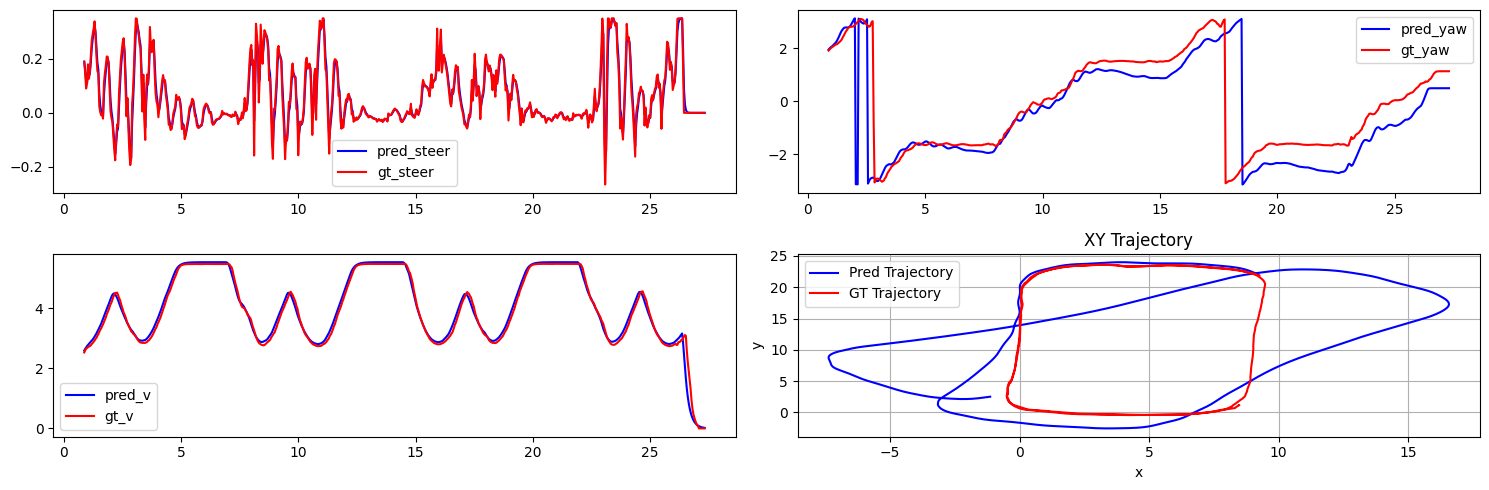

Epoch: 40 | Training Loss: 0.4865002930164337 | Validation Loss: 2.964753473352755 | LR: 0.007290000000000001
Epoch: 40 | Training Loss: 0.4865002930164337 | Validation Loss: 2.964753473352755 | LR: 0.007290000000000001
Epoch: 41 | Training Loss: 0.4864998757839203 | Validation Loss: 2.964753473352755 | LR: 0.007290000000000001
Epoch: 42 | Training Loss: 0.486499547958374 | Validation Loss: 2.964753473352755 | LR: 0.007290000000000001
Epoch: 43 | Training Loss: 0.48649919033050537 | Validation Loss: 2.964753473352755 | LR: 0.007290000000000001
Epoch: 44 | Training Loss: 0.48649895191192627 | Validation Loss: 2.964753473352755 | LR: 0.007290000000000001
accel_max tensor(10., device='cuda:0') tensor(0., device='cuda:0')
accel_min tensor(-9.9999, device='cuda:0') tensor(-5.1966e-05, device='cuda:0')
steer_k tensor(0.7932) tensor(0.0026)
Epoch: 45 | Training Loss: 0.4864986538887024 | Validation Loss: 2.964753473352755 | LR: 0.006561000000000002
Epoch: 46 | Training Loss: 0.486498266458511

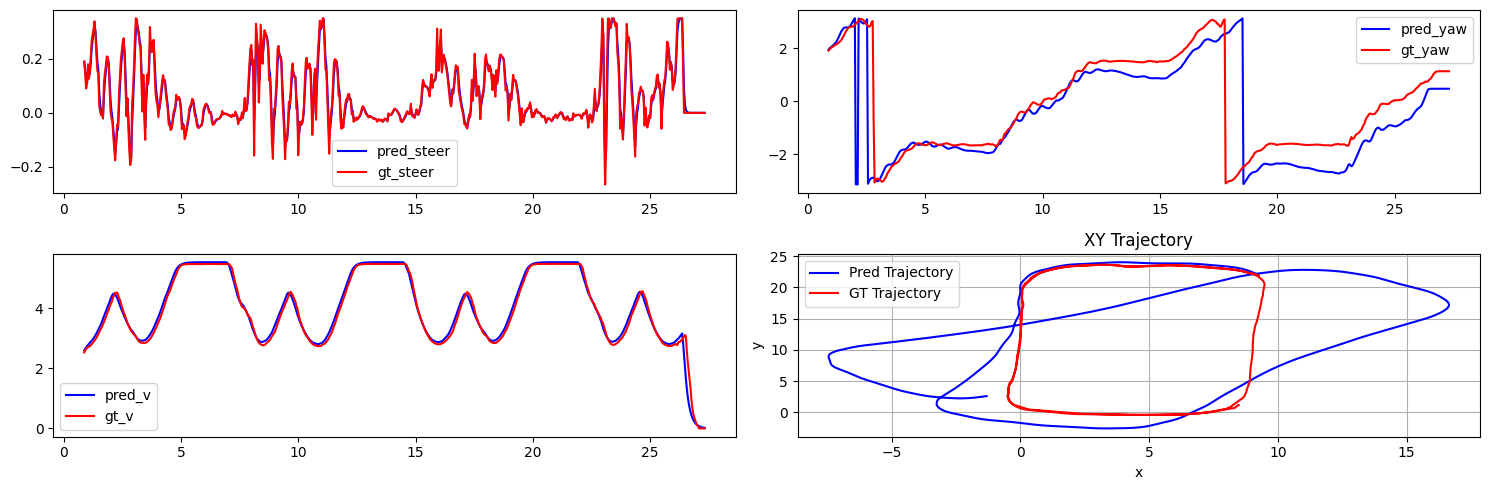

Epoch: 60 | Training Loss: 0.48649704456329346 | Validation Loss: 3.020755286799768 | LR: 0.005904900000000002
Epoch: 60 | Training Loss: 0.48649704456329346 | Validation Loss: 3.020755286799768 | LR: 0.005904900000000002
Epoch: 61 | Training Loss: 0.48649704456329346 | Validation Loss: 3.020755286799768 | LR: 0.005904900000000002
Epoch: 62 | Training Loss: 0.48649701476097107 | Validation Loss: 3.020755286799768 | LR: 0.005904900000000002
Epoch: 63 | Training Loss: 0.48649686574935913 | Validation Loss: 3.020755286799768 | LR: 0.005904900000000002
Epoch: 64 | Training Loss: 0.48649686574935913 | Validation Loss: 3.020755286799768 | LR: 0.005904900000000002
accel_max tensor(10., device='cuda:0') tensor(0., device='cuda:0')
accel_min tensor(-9.9999, device='cuda:0') tensor(-5.1938e-05, device='cuda:0')
steer_k tensor(0.7925) tensor(8.5472e-05)
Epoch: 65 | Training Loss: 0.48649707436561584 | Validation Loss: 3.020755286799768 | LR: 0.005904900000000002
Epoch: 66 | Training Loss: 0.48649

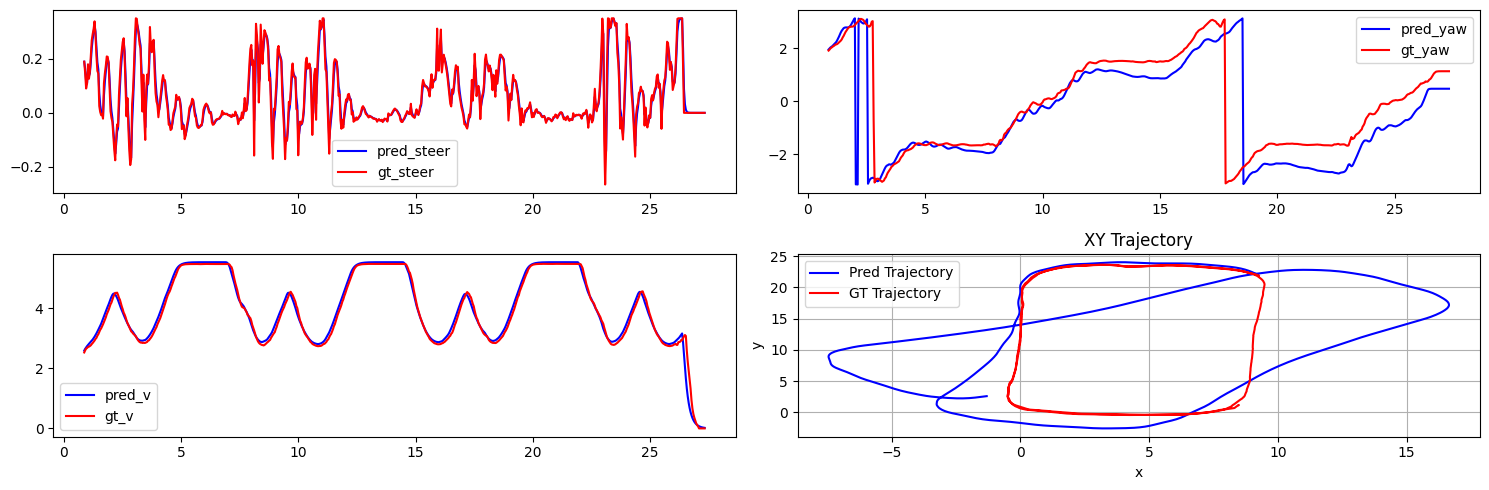

Epoch: 80 | Training Loss: 0.4864969849586487 | Validation Loss: 3.0194342335958053 | LR: 0.004782969000000002
Epoch: 80 | Training Loss: 0.4864969849586487 | Validation Loss: 3.0194342335958053 | LR: 0.004782969000000002
Epoch: 81 | Training Loss: 0.48649704456329346 | Validation Loss: 3.0194342335958053 | LR: 0.004782969000000002
Epoch: 82 | Training Loss: 0.4864969849586487 | Validation Loss: 3.0194342335958053 | LR: 0.004782969000000002
Epoch: 83 | Training Loss: 0.48649704456329346 | Validation Loss: 3.0194342335958053 | LR: 0.004782969000000002
Epoch: 84 | Training Loss: 0.4864969849586487 | Validation Loss: 3.0194342335958053 | LR: 0.004782969000000002
accel_max tensor(10., device='cuda:0') tensor(0., device='cuda:0')
accel_min tensor(-9.9999, device='cuda:0') tensor(-5.1938e-05, device='cuda:0')
steer_k tensor(0.7924) tensor(8.8811e-05)
Epoch: 85 | Training Loss: 0.4864969849586487 | Validation Loss: 3.0194342335958053 | LR: 0.004782969000000002
Epoch: 86 | Training Loss: 0.486

In [397]:
losses = list()
lrs = list()
# torch.autograd.set_detect_anomaly(False)
for i in tqdm(range(EPOCHS)):
    for initial, inputs, targets in dataloader:
        optimizer.zero_grad()
        pred_states = rk4_integrator(initial, inputs)
        loss = kinematic_steer_loss(pred_states, targets, params_index=params_index)
        loss.backward()
        optimizer.step()
    if i%5 == 0:
        for name, param in kinematic_f110.named_parameters():
           if param.requires_grad:
               print(name, param.data, param.grad)
    if i%20 == 0:
        with torch.no_grad():
            pred = rk4_integrator(initial_state, control_inputs)
            val_loss = kinematic_steer_loss(pred, output_states, params_index=params_index)
        plot_states(pred.cpu().detach().numpy(), output_states.cpu().detach().numpy(), ti)
        print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    # with torch.no_grad():
    #     output_states = integrator(batched_initial_states,batched_control_inputs)
    #     val_loss = torch.nn.functional.l1_loss(output_states, batched_target_states)
    #     losses.append(val_loss.item())
    print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step(val_loss)


In [ ]:
# def integrator(dynamic_model, initial_states, control_inputs, ti):
#     """
#     Take batch data as input
#     """
#     def u_func(t):
#         t_interval = (t-ti[0]).item()
#         u_idx = int(t_interval/sample_interval)
#         return control_inputs[:, u_idx, :]
#     func = lambda t, x: dynamic_model(x, u_func(t))
#     # odeint give output of shape(horizon, bs, dim), so do a permute here
#     trajectory = odeint(func, initial_states, ti).permute(1, 0, 2)

#     return trajectory

# def oneD_integrator(dynamic_model, initial_states, control_inputs, ti):
#     def u_func(t):
#         t_interval = (t-ti[0]).item()
#         u_idx = int(t_interval/sample_interval)
#         return control_inputs[u_idx, :]
#     func = lambda t, x: dynamic_model(x, u_func(t))
#     trajectory = odeint(func, initial_states, ti)

#     return trajectory